In [1]:
import os 
import numpy as np
import torch
from utils1 import * 
import h5py
import random
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
from sklearn.model_selection import train_test_split
# os.environ["CUDA_VISIBLE_DEVICES"] = "1" 
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import precision_recall_fscore_support
from matplotlib.pyplot import savefig
import tensorflow as tf
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.models as models
from torchsummary import summary
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix,ConfusionMatrixDisplay
import h5py
import pandas as pd
from tqdm import tqdm

import random
import numpy as np
from PIL import Image  
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import models, layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import ResNet50

2023-10-05 00:22:03.579591: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-10-05 00:22:03.629946: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-05 00:22:04.452460: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [82]:
def imgs_input_fn(images):
    img_size = (224, 224, 3)
    images = tf.convert_to_tensor(value = images)
    images = tf.image.resize(images, size=img_size[:2])
    return images

In [2]:
def evaluate_and_plot(y_true, y_pred):
    conf_matrix = confusion_matrix(y_true, y_pred)
    precision, recall, f1_score, support = precision_recall_fscore_support(y_true, y_pred, average='binary')

    # Plot the confusion matrix
    plt.figure(figsize=(3, 2))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False,
                xticklabels=["Not bk", "bk"],
                yticklabels=["Not bk", "bk"])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix');
    # print("Confusion Matrix:")
    # print(conf_matrix)
    # print("\nClassification Report:")
    # print(classification_report(y_true, y_pred))
    print(f"Accuracy: {accuracy_score(y_true, y_pred)}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1 Score: {f1_score}")

In [3]:
ind_data ='/home/rishabh.mondal/Indian_dataset.h5'

In [4]:
def load_hdf5_data_cust(file_path):
    with h5py.File(file_path, 'r') as h5_file:
        images = np.array(h5_file['image'])
        labels = np.array(h5_file['label'])    
    print("Images shape: ", images.shape) #, 'Images dtype: ', images.dtype)
    print("Labels shape: ", labels.shape) #, 'Labels dtype: ', labels.dtype)
    return images, labels

In [5]:
images, labels = load_hdf5_data_cust(ind_data) 

Images shape:  (2758, 236, 256, 3)
Labels shape:  (2758,)


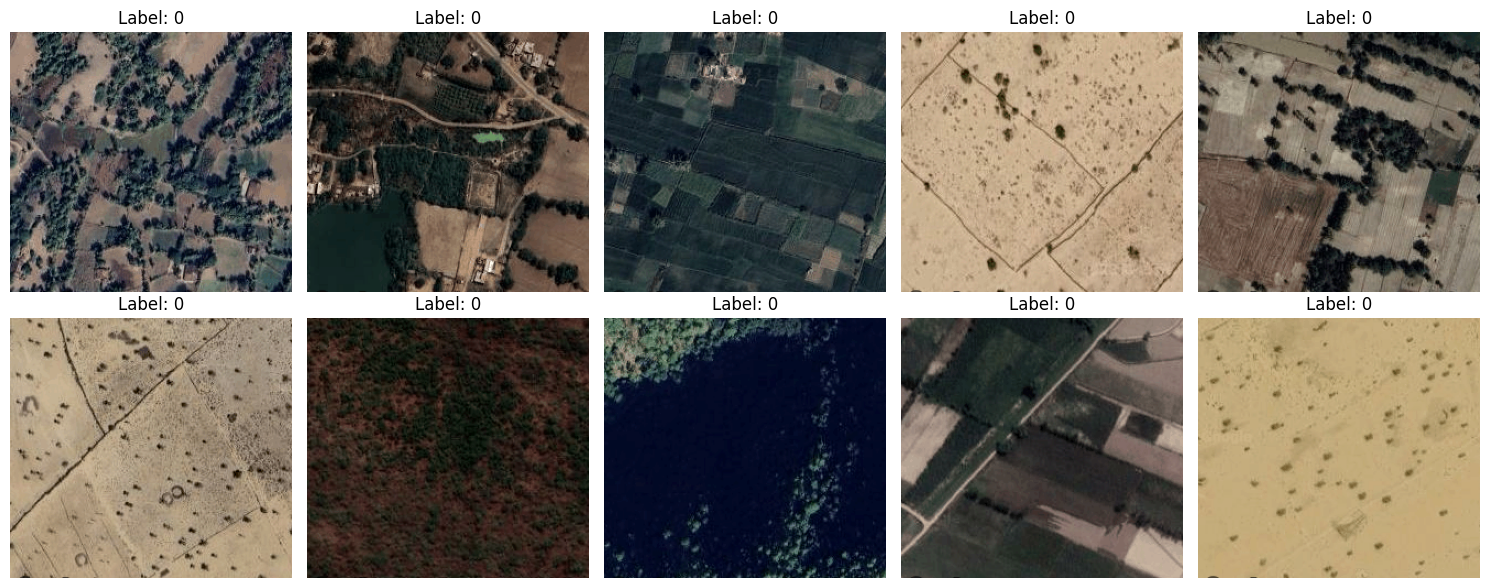

In [87]:
show_random_images_with_labels(ind_data, num_images=10)

In [13]:
def tts_india():
    file_path = ind_data # replace with the path to the dataset
    
    X_train, Y_train = load_hdf5_data(file_path)
    
    X_train, X_test, Y_train, Y_test = train_test_split(X_train, Y_train, test_size=0.2, stratify=Y_train, random_state=0)
    X_train, X_pool, Y_train, Y_pool = train_test_split(X_train, Y_train, test_size=0.99, stratify = Y_train, random_state=0)
  
    X_train = np.array(imgs_input_fn(X_train))
    X_pool = np.array(imgs_input_fn(X_pool))
    X_test = np.array(imgs_input_fn(X_test))

    return X_train, X_pool, X_test, Y_train, Y_pool, Y_test

In [14]:
X_train, X_pool, X_test, Y_train, Y_pool, Y_test = tts_india()


Images shape:  (2758, 236, 256, 3)
Labels shape:  (2758,)


In [90]:
print("X_train shape: ", X_train.shape)
print("Y_train shape: ", Y_train.shape)
print("X_pool shape: ", X_pool.shape)
print("Y_pool shape: ", Y_pool.shape)
print("X_test shape: ", X_test.shape)
print("Y_test shape: ", Y_test.shape)

X_train shape:  (22, 224, 224, 3)
Y_train shape:  (22,)
X_pool shape:  (2184, 224, 224, 3)
Y_pool shape:  (2184,)
X_test shape:  (552, 224, 224, 3)
Y_test shape:  (552,)


In [91]:
# label of training data
print("Y_train: ", Y_train)

Y_train:  [0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0.]


In [92]:
# Active learning loop parameters
num_iterations = 100
batch_size = 32
num_label = 1
num_mc_samples = 10

In [10]:
def resnet_model(learning_rate=0.00002):
    # load model
    model = models.Sequential()
    conv_base = ResNet50(weights = 'imagenet', include_top=False, input_shape=(224, 224, 3))
    conv_base.trainable = False # not fine tuning 
    model.add(conv_base)
    
    model.add(layers.AveragePooling2D(pool_size=(7,7)))
    model.add(layers.Flatten())
    model.add(layers.Dense(2048, activation='relu'))
    model.add(layers.Dropout(0.2))
    model.add(layers.Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy',
    	      optimizer=Adam(learning_rate=learning_rate), metrics=['acc'])
    return model

In [94]:
model = resnet_model(learning_rate=0.00002)
model.fit(X_train, Y_train, batch_size=batch_size, epochs=10, verbose=0)


In [95]:
pool_predictions = model.predict(X_pool)


69/69 [==============================] - 42s 602ms/step


18/18 [==============================] - 11s 590ms/step


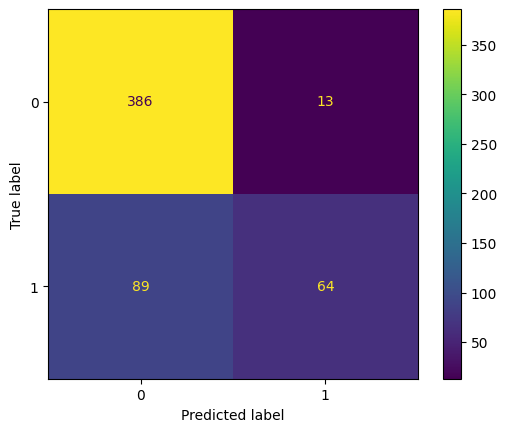

In [96]:
from sklearn.metrics import precision_score, recall_score, f1_score
Y_pred = np.round(model.predict(X_test))
conf_matrix = confusion_matrix(Y_test, Y_pred)
cm_display = ConfusionMatrixDisplay(confusion_matrix = conf_matrix, display_labels = ['0', '1'])
cm_display.plot()
precision = precision_score(Y_test, Y_pred)
recall = recall_score(Y_test, Y_pred)
f1 = f1_score(Y_test,Y_pred)

In [105]:
# print("predictions: ", pool_predictions)
print("predictions shape: ", pool_predictions.shape)

predictions shape:  (2184, 1)


In [112]:
positive_predictions = []
positive_predictions = pool_predictions[pool_predictions > 0.5]
print("Number of positive predictions: ", len(positive_predictions))
#print that index of minimum value of positive predictions
print("Index of minimum value positive predictions: ", np.argmin(positive_predictions))
selected_indices=np.argmin(positive_predictions)

selected_images = X_pool[selected_indices][np.newaxis, :]

print("selected_images shape: ", selected_images.shape)

#add that index image with my training data with label
selected_indices = Y_pool[selected_indices]
print(selected_indices)



print(X_train.shape)
print(X_pool.shape)
print(Y_train.shape)
# print(X_pool[selected_indices].shape)
X_train = np.concatenate((X_train, selected_images), axis=0)
Y_train = np.append(Y_train, selected_indices)

# Y_train = np.concatenate((Y_train, selected_indices), axis=0)


selected_indices = selected_indices.astype(int)

# # Delete the selected index image from your pool data
X_pool = np.delete(X_pool, selected_indices, axis=0)
Y_pool = np.delete(Y_pool, selected_indices, axis=0)

print("X_train shape: ", X_train.shape)
print("Y_train shape: ", Y_train.shape)
print("X_pool shape: ", X_pool.shape)
print("Y_pool shape: ", Y_pool.shape)






Number of positive predictions:  321
Index of 10 minimum values positive predictions:  [310 136 154  33  54]
Probality of 10 minimum values positive predictions:  [0.5028939  0.50238436 0.50015795 0.5054867  0.505674  ]
Index of minimum value positive predictions:  154
selected_images shape:  (1, 224, 224, 3)
1.0
(28, 224, 224, 3)
(2183, 224, 224, 3)
(28,)
X_train shape:  (29, 224, 224, 3)
Y_train shape:  (29,)
X_pool shape:  (2182, 224, 224, 3)
Y_pool shape:  (2182,)


In [103]:
model.fit(X_train, Y_train, batch_size=batch_size, epochs=10, verbose=0)


18/18 [==============================] - 11s 602ms/step
Accuracy: 0.8442028985507246
Precision: 0.9135802469135802
Recall: 0.48366013071895425
F1 Score: 0.6324786324786325


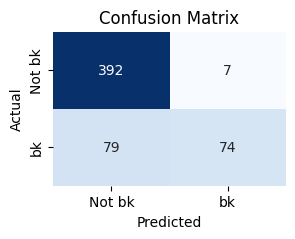

In [104]:
evaluate_and_plot(Y_test, np.round(model.predict(X_test)))

In [17]:
def tts_india():
    file_path = ind_data # replace with the path to the dataset
    
    X_train, Y_train = load_hdf5_data(file_path)
    
    X_train, X_test, Y_train, Y_test = train_test_split(X_train, Y_train, test_size=0.2, stratify=Y_train, random_state=0)
    X_train, X_pool, Y_train, Y_pool = train_test_split(X_train, Y_train, test_size=0.99, stratify = Y_train, random_state=0)
  
    X_train = np.array(imgs_input_fn(X_train))
    X_pool = np.array(imgs_input_fn(X_pool))
    X_test = np.array(imgs_input_fn(X_test))

    return X_train, X_pool, X_test, Y_train, Y_pool, Y_test

In [ ]:
X_train, Y_train = load_hdf5_data(file_path)

X_train, X_test, Y_train, Y_test = train_test_split(X_train, Y_train, test_size=0.2, stratify=Y_train, random_state=0)
X_train, X_pool, Y_train, Y_pool = train_test_split(X_train, Y_train, test_size=0.99, stratify = Y_train, random_state=0)


In [19]:
def al_loop(num_iterations = 100, batch_size = 32, num_label = 1, num_mc_samples = 10, rand_num = 0):
    # Reinitialise model
    model = resnet_model(learning_rate=0.00002)
    
    X_train = np.array(imgs_input_fn(X_train))
    X_pool = np.array(imgs_input_fn(X_pool))
    X_test = np.array(imgs_input_fn(X_test))
    
    initial_epoch = 100
    subsequent_epoch = 5

    # Lists to store the test loss and accuracy for each iteration
    test_loss_list = []
    test_accuracy_list = []
    precision_list = []
    recall_list = []
    f1_score_list = []


    save_folder = "acquired_"
    # save_folder += case
    # save_folder += entropy
    # if not os.path.exists(save_folder):
    #     os.makedirs(save_folder)

    for iteration in tqdm(range(num_iterations)):
        print(f"Iteration {iteration + 1}")
        
        # Train the model on the labeled data
        if(iteration==0):
            model.fit(X_train, Y_train, batch_size=batch_size, epochs=initial_epoch, verbose=0)
        else:
            model.fit(X_train, Y_train, batch_size=batch_size, epochs=subsequent_epoch, verbose=0)

        # Evaluate the model on the test set and store the metrics
        test_loss, test_accuracy = model.evaluate(X_test, Y_test, verbose=0)
        test_loss_list.append(test_loss)
        test_accuracy_list.append(test_accuracy)
        
        # # Get predictions on the test set
        Y_pred = np.round(model.predict(X_test))
        evaluate_and_plot(Y_test, Y_pred)
        # Calculate precision and recall for the test set
        precision = precision_score(Y_test, Y_pred)
        recall = recall_score(Y_test, Y_pred)
        f1 = f1_score(Y_test,Y_pred)

        precision_list.append(precision)
        recall_list.append(recall)
        f1_score_list.append(f1)

        # Forward passes
        
        predictions = [model(X_pool, training = True) for _ in range(num_mc_samples)]
        predictions = np.array(predictions)
        complementary_predictions = 1 - predictions
        predictions = np.concatenate((predictions, complementary_predictions), axis=2)
        selected_indices = [random_array[rand_num][iteration]]

        pool_predictions = model.predict(X_pool)
        positive_predictions = pool_predictions[pool_predictions > 0.5]
        selected_indices = np.argmin(positive_predictions)
        
        X_train = np.concatenate((X_train, X_pool[selected_indices][np.newaxis, :]), axis=0)
        Y_train = np.append(Y_train, selected_indices)

        image_data = X_pool[selected_indices[0]]  # Assuming X_pool contains image data
        image = Image.fromarray((image_data))
        selected_image_path = os.path.join(save_folder, f"iteration{iteration}.jpg")
        image.save(selected_image_path)

        selected_indices = selected_indices.astype(int)
        X_pool = np.delete(X_pool, selected_indices, axis=0)
        Y_pool = np.delete(Y_pool, selected_indices, axis=0)    
        

    for i, (loss, accuracy, precision, recall) in enumerate(zip(test_loss_list, test_accuracy_list, precision_list, recall_list), 1):
        print(f"Iteration {i}: Test Loss = {loss:.4f}, Test Accuracy = {accuracy:.4f}, Precision = {precision:.4f}, Recall = {recall:.4f}")

    d1 = pd.DataFrame(precision_list)
    d2 = pd.DataFrame(recall_list)
    d3 = pd.DataFrame(test_accuracy_list)
    d4 = pd.DataFrame(f1_score_list)
    d5 = pd.DataFrame(test_loss_list)
    return test_loss_list, test_accuracy_list, precision_list, recall_list, f1_score_list

In [20]:
test_loss_list, test_accuracy_list, precision_list, recall_list, f1_score_list = al_loop()

Images shape:  (2758, 236, 256, 3)
Labels shape:  (2758,)


  0%|          | 0/100 [00:00<?, ?it/s]

Iteration 1


  0%|          | 0/100 [00:00<?, ?it/s]


ValueError: in user code:

    File "/home/rishabh.mondal/miniconda3/envs/torch_env/lib/python3.11/site-packages/keras/src/engine/training.py", line 1338, in train_function  *
        return step_function(self, iterator)
    File "/home/rishabh.mondal/miniconda3/envs/torch_env/lib/python3.11/site-packages/keras/src/engine/training.py", line 1322, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/rishabh.mondal/miniconda3/envs/torch_env/lib/python3.11/site-packages/keras/src/engine/training.py", line 1303, in run_step  **
        outputs = model.train_step(data)
    File "/home/rishabh.mondal/miniconda3/envs/torch_env/lib/python3.11/site-packages/keras/src/engine/training.py", line 1080, in train_step
        y_pred = self(x, training=True)
    File "/home/rishabh.mondal/miniconda3/envs/torch_env/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/home/rishabh.mondal/miniconda3/envs/torch_env/lib/python3.11/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_2" is incompatible with the layer: expected shape=(None, 224, 224, 3), found shape=(None, 236, 224, 224)


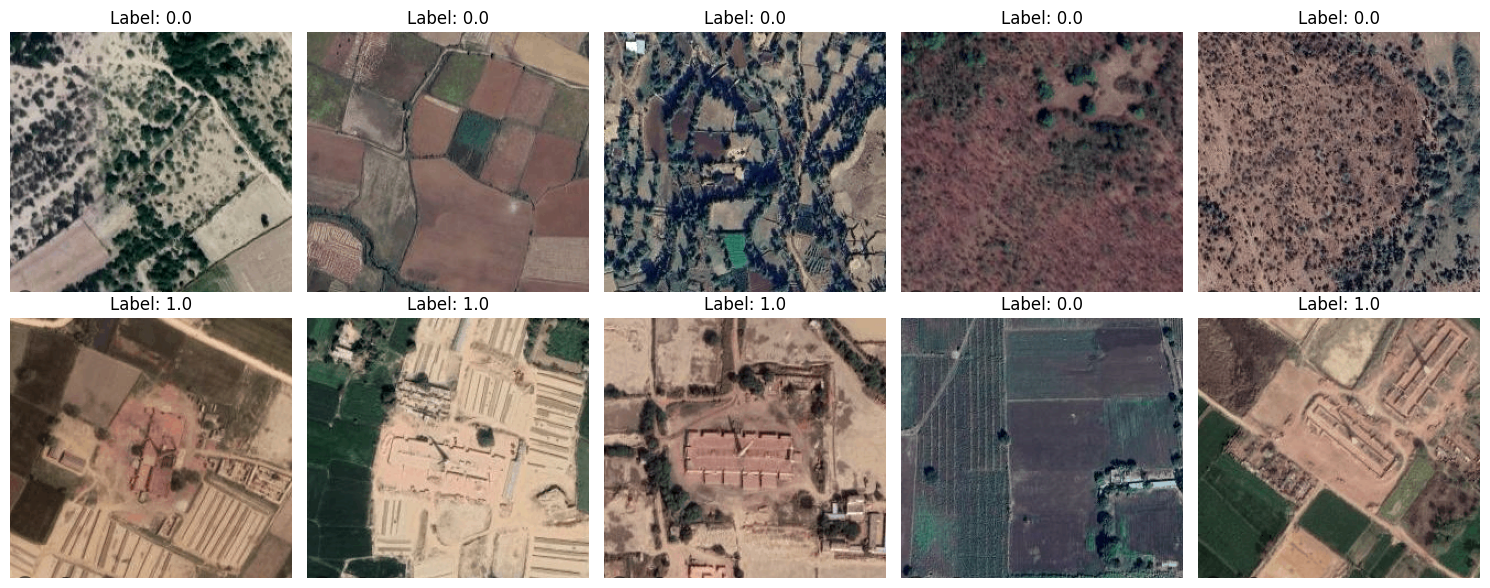

In [99]:
import h5py
import random
import matplotlib.pyplot as plt

def show_images_with_labels_by_indices(hdf5_file, indices):
    with h5py.File(hdf5_file, "r") as f:
        images = f["image"]
        labels = f["label"]

        num_indices = len(indices)
        num_rows = (num_indices + 4) // 5

        fig, axes = plt.subplots(num_rows, 5, figsize=(15, 3 * num_rows))
        
        for i, index in enumerate(indices):
            row = i // 5
            col = i % 5
            image = images[index]
            label = labels[index]

            ax = axes[row, col]
            ax.imshow(image)
            ax.set_title(f"Label: {label}")
            ax.axis("off")

        for i in range(num_indices % 5, 5):
            axes[num_rows - 1, i].axis("off")

        plt.tight_layout()
        plt.show()

# Example usage:
# Assuming you have an HDF5 file named 'data.h5' and a list of indices to display
indices_to_show = np.argpartition(positive_predictions, 10)[:10]
show_images_with_labels_by_indices(ind_data, indices_to_show)


Indices to show:  [254  72 136  54 154  33 295 310 189 246]
Probabilities to show:  [0.5066772  0.5067454  0.50238436 0.505674   0.50015795 0.5054867
 0.5058071  0.5028939  0.5067773  0.507729  ]


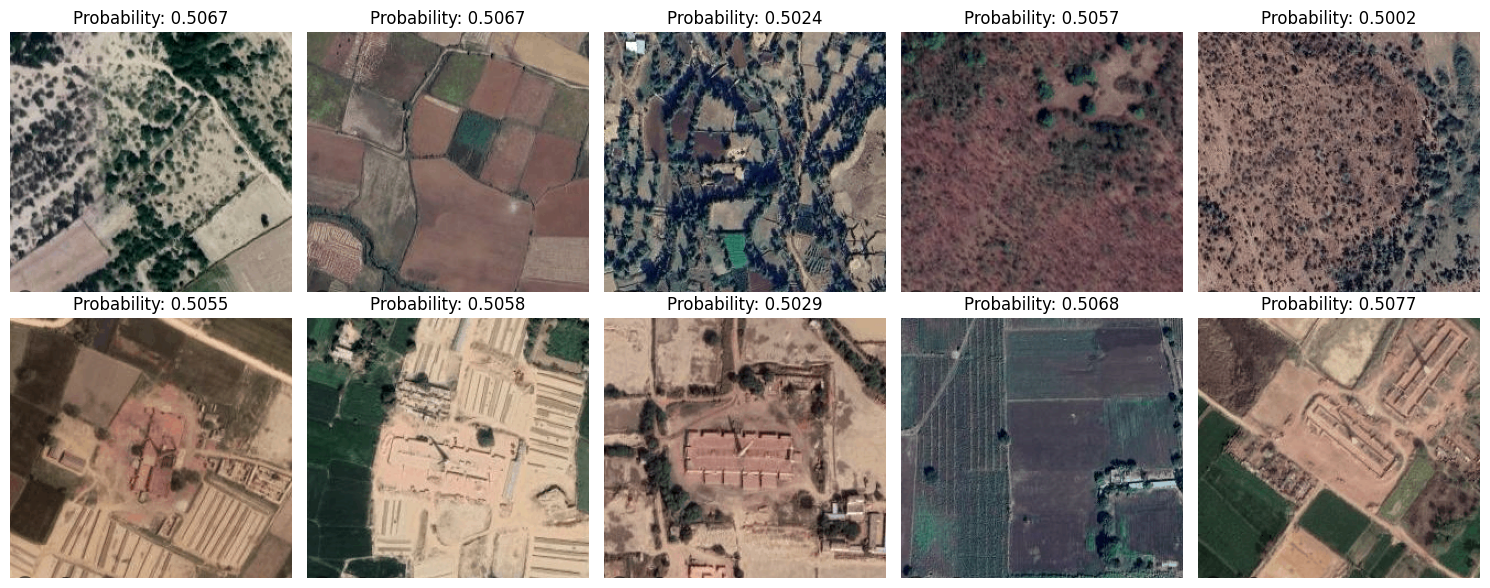

In [100]:
def show_images_with_probabilities_by_indices(hdf5_file, indices, probabilities):
    with h5py.File(hdf5_file, "r") as f:
        images = f["image"]

        num_indices = len(indices)
        num_rows = (num_indices + 4) // 5

        fig, axes = plt.subplots(num_rows, 5, figsize=(15, 3 * num_rows))
        
        for i, index in enumerate(indices):
            row = i // 5
            col = i % 5
            image = images[index]
            prob = probabilities[i]

            ax = axes[row, col]
            ax.imshow(image)
            ax.set_title(f"Probability: {prob:.4f}")
            ax.axis("off")

        for i in range(num_indices % 5, 5):
            axes[num_rows - 1, i].axis("off")

        plt.tight_layout()
        plt.show()

# Example usage:
# Assuming you have an HDF5 file named 'data.h5', a list of indices to display, and corresponding probabilities
indices_to_show = np.argpartition(positive_predictions, 10)[:10]
print("Indices to show: ", indices_to_show)
probabilities_to_show = positive_predictions[indices_to_show]
print("Probabilities to show: ", probabilities_to_show)
show_images_with_probabilities_by_indices(ind_data, indices_to_show, probabilities_to_show)


y_pred_labels:  [[0.]
 [0.]
 [0.]
 ...
 [0.]
 [1.]
 [0.]]


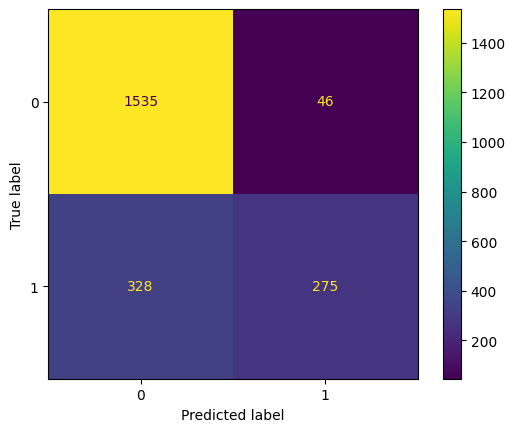

In [101]:
y_pred_labels = np.round(pool_predictions)
print("y_pred_labels: ", y_pred_labels)
conf_matrix = confusion_matrix(Y_pool, y_pred_labels)
cm_display = ConfusionMatrixDisplay(confusion_matrix = conf_matrix, display_labels = ['0', '1'])
cm_display.plot()

In [102]:
train_dataset = TensorDataset(torch.tensor(x_train, dtype=torch.float32).permute(0, 3, 1, 2), torch.tensor(y_train, dtype=torch.float32))
pool_dataset = TensorDataset(torch.tensor(x_pool, dtype=torch.float32).permute(0, 3, 1, 2), torch.tensor(y_pool, dtype=torch.float32))
test_dataset = TensorDataset(torch.tensor(x_test, dtype=torch.float32).permute(0, 3, 1, 2), torch.tensor(y_test, dtype=torch.float32))

batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
pool_loader = DataLoader(pool_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

NameError: name 'x_train' is not defined

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [ ]:
from efficientnet_pytorch import EfficientNet

def efficientnet_b0_model(learning_rate=0.00002, fine_tune=True, seed=4):
    torch.manual_seed(seed)
    model = EfficientNet.from_pretrained('efficientnet-b0')
    
    if fine_tune:
        for param in model.parameters():
            param.requires_grad = True
    
    num_features = model._fc.in_features
    model._fc = nn.Sequential(
        nn.Linear(num_features, 256),
        nn.ReLU(),
        nn.Dropout(p=0.2, inplace=False),
        nn.Linear(256, 1),
        nn.Sigmoid()
    )
    criterion = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
    return model, criterion, optimizer


In [ ]:
model, criterion, optimizer = efficientnet_b0_model(seed=4)
model = model.to(device)
train_losses = []
train_accuracies = []
num_epochs = 100

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    total_samples = 0
    total_correct = 0
    for images,labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        output = model(images)
        output = output.squeeze(dim=1)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        total_samples += labels.size(0)
        total_correct += (output.round() == labels).sum().item()

        epoch_loss = train_loss / len(train_loader)
        epoch_acc = (total_correct / total_samples)*100
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_acc)
    # print(f'Epoch {epoch+1}/{num_epochs}, Training Loss: {epoch_loss:.4f}, Training Accuracy: {epoch_acc:.4f}')


Loaded pretrained weights for efficientnet-b0


In [ ]:
from torchvision import transforms

# Create directories to save true positive and false positive images
true_positive_dir = "true_positive_images"
false_positive_dir = "false_positive_images"

os.makedirs(true_positive_dir, exist_ok=True)
os.makedirs(false_positive_dir, exist_ok=True)

# Define a transformation to convert tensor to PIL image
transform = transforms.ToPILImage()

true_labels_pool = []
predicted_labels_pool = []
model.eval()  
test_loss = 0.0
pool_total_samples = 0
pool_total_correct = 0
#
with torch.no_grad():  
    for i, (images, labels) in enumerate(pool_loader):
        images = images.to(device)
        labels = labels.to(device)
        output = model(images)
        output = output.squeeze(dim=1)

        loss = criterion(output, labels)
        test_loss += loss.item()

        predicted = (output.round() == 1.0)  
        true_labels_pool.extend(labels.cpu().numpy())
        predicted_labels_pool.extend(predicted.cpu().numpy())

        pool_total_samples += labels.size(0)
        pool_total_correct += (output.round() == labels).sum().item()

        # Save images classified as true positives and false positives
        for j in range(len(images)):
            if predicted[j] == 1 and labels[j] == 1:
                # Save true positive image
                img = transform(images[j].cpu())
                # img.save(os.path.join(true_positive_dir, f"true_positive_{i * pool_loader.batch_size + j}.png"))
            elif predicted[j] == 1 and labels[j] == 0:
                # Save false positive image
                img = transform(images[j].cpu())
                img.save(os.path.join(false_positive_dir, f"false_positive_{i * pool_loader.batch_size + j}.png"))

# pool_accuracy = (pool_total_correct / pool_total_samples) * 100
# print(pool_accuracy)


Accuracy: 0.8
Precision: 0.07614213197969544
Recall: 0.05639097744360902
F1 Score: 0.06479481641468682


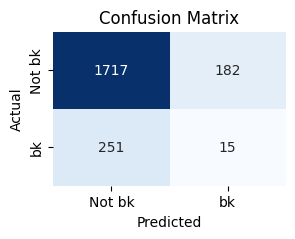

In [ ]:
evaluate_and_plot(true_labels_pool, predicted_labels_pool)

In [ ]:
# Assuming X_pool and y_pool are your pool data and labels
true_positive_indices = [i for i, (true_label, pred_label) in enumerate(zip(true_labels_pool, predicted_labels_pool)) if true_label == 1 and pred_label == 1]
false_positive_indices = [i for i, (true_label, pred_label) in enumerate(zip(true_labels_pool, predicted_labels_pool)) if true_label == 0 and pred_label == 1]

# Add true positives to the train dataset
x_train = np.vstack((x_train, x_pool[true_positive_indices]))
y_train = np.append(y_train, np.ones(len(true_positive_indices)))

# Add false positives to the train dataset
x_train = np.vstack((x_train, x_pool[false_positive_indices]))
y_train = np.append(y_train, np.zeros(len(false_positive_indices)))


In [ ]:

# Drop true positives from pool data
x_pool = np.delete(x_pool, true_positive_indices, axis=0)
y_pool = np.delete(y_pool, true_positive_indices, axis=0)

# Drop false positives from pool data
x_pool = np.delete(x_pool, false_positive_indices, axis=0)
y_pool = np.delete(y_pool, false_positive_indices, axis=0)


In [ ]:
print(x_train.shape)
print(x_pool.shape)

(218, 256, 256, 3)
(1968, 256, 256, 3)


In [ ]:
resized_x_train = np.zeros((x_train.shape[0], 224, 224, 3), dtype=np.uint8)
print(resized_x_train.shape)
resized_x_test = np.zeros((x_test.shape[0], 224, 224, 3), dtype=np.uint8)
resized_x_val = np.zeros((x_pool.shape[0], 224, 224, 3), dtype=np.uint8)
for i in range(x_train.shape[0]):
    img = Image.fromarray(x_train[i])
    img = img.resize((224, 224), Image.ANTIALIAS)
    resized_x_train[i] = np.array(img)

for i in range(x_test.shape[0]):
    img = Image.fromarray(x_test[i])
    img = img.resize((224, 224), Image.ANTIALIAS)
    resized_x_test[i] = np.array(img)

for i in range(x_pool.shape[0]):
    img = Image.fromarray(x_pool[i])
    img = img.resize((224, 224), Image.ANTIALIAS)
    resized_x_val[i] = np.array(img)

(218, 224, 224, 3)


/tmp/ipykernel_560068/1686197677.py:7: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = img.resize((224, 224), Image.ANTIALIAS)
/tmp/ipykernel_560068/1686197677.py:12: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = img.resize((224, 224), Image.ANTIALIAS)
/tmp/ipykernel_560068/1686197677.py:17: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = img.resize((224, 224), Image.ANTIALIAS)


In [ ]:
train_dataset = TensorDataset(torch.tensor(x_train, dtype=torch.float32).permute(0, 3, 1, 2), torch.tensor(y_train, dtype=torch.float32))
pool_dataset = TensorDataset(torch.tensor(x_pool, dtype=torch.float32).permute(0, 3, 1, 2), torch.tensor(y_pool, dtype=torch.float32))

batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
pool_loader = DataLoader(pool_dataset, batch_size=batch_size)

In [ ]:
true_labels = []
predicted_labels = []
model.eval()  
test_loss = 0.0
test_total_samples = 0
test_total_correct = 0
with torch.no_grad():  
    for images,labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        output = model(images)
        output = output.squeeze(dim=1)

        loss = criterion(output, labels)
        test_loss += loss.item()

        predicted = (output.round() == 1.0)  
        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(predicted.cpu().numpy())        

        test_total_samples += labels.size(0)
        test_total_correct += (output.round() == labels).sum().item()

    test_accuracy = (test_total_correct / test_total_samples) * 100
    print(test_accuracy)

81.71521035598705


Accuracy: 0.8171521035598706
Precision: 0.08333333333333333
Recall: 0.0547945205479452
F1 Score: 0.06611570247933884


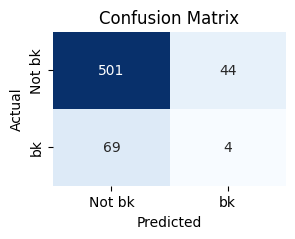

In [ ]:
evaluate_and_plot(true_labels, predicted_labels)

In [ ]:
model, criterion, optimizer = efficientnet_b0_model(seed=4)
model = model.to(device)
train_losses = []
train_accuracies = []
num_epochs = 100

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    total_samples = 0
    total_correct = 0
    for images,labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        output = model(images)
        output = output.squeeze(dim=1)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        total_samples += labels.size(0)
        total_correct += (output.round() == labels).sum().item()

        epoch_loss = train_loss / len(train_loader)
        epoch_acc = (total_correct / total_samples)*100
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_acc)

Loaded pretrained weights for efficientnet-b0


In [ ]:
true_labels = []
predicted_labels = []
model.eval()  
test_loss = 0.0
test_total_samples = 0
test_total_correct = 0
with torch.no_grad():  
    for images,labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        output = model(images)
        output = output.squeeze(dim=1)

        loss = criterion(output, labels)
        test_loss += loss.item()

        predicted = (output.round() == 1.0)  
        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(predicted.cpu().numpy())        

        test_total_samples += labels.size(0)
        test_total_correct += (output.round() == labels).sum().item()

    test_accuracy = (test_total_correct / test_total_samples) * 100
    print(test_accuracy)

92.71844660194175


Accuracy: 0.9271844660194175
Precision: 0.7
Recall: 0.6712328767123288
F1 Score: 0.6853146853146853


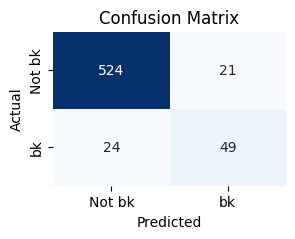

In [ ]:
evaluate_and_plot(true_labels, predicted_labels)

In [ ]:
from torchvision import transforms

# Create directories to save true positive and false positive images
true_positive_dir = "true_positive_images"
false_positive_dir = "false_positive_images"

os.makedirs(true_positive_dir, exist_ok=True)
os.makedirs(false_positive_dir, exist_ok=True)

# Define a transformation to convert tensor to PIL image
transform = transforms.ToPILImage()

true_labels_pool = []
predicted_labels_pool = []
model.eval()  
test_loss = 0.0
pool_total_samples = 0
pool_total_correct = 0
#
with torch.no_grad():  
    for i, (images, labels) in enumerate(pool_loader):
        images = images.to(device)
        labels = labels.to(device)
        output = model(images)
        output = output.squeeze(dim=1)

        loss = criterion(output, labels)
        test_loss += loss.item()

        predicted = (output.round() == 1.0)  
        true_labels_pool.extend(labels.cpu().numpy())
        predicted_labels_pool.extend(predicted.cpu().numpy())

        pool_total_samples += labels.size(0)
        pool_total_correct += (output.round() == labels).sum().item()

        # Save images classified as true positives and false positives
        for j in range(len(images)):
            if predicted[j] == 1 and labels[j] == 1:
                # Save true positive image
                img = transform(images[j].cpu())
                # img.save(os.path.join(true_positive_dir, f"true_positive_{i * pool_loader.batch_size + j}.png"))
            elif predicted[j] == 1 and labels[j] == 0:
                # Save false positive image
                img = transform(images[j].cpu())
                img.save(os.path.join(false_positive_dir, f"false_positive_{i * pool_loader.batch_size + j}.png"))

# pool_accuracy = (pool_total_correct / pool_total_samples) * 100
# print(pool_accuracy)


Accuracy: 0.9329268292682927
Precision: 0.7659574468085106
Recall: 0.6206896551724138
F1 Score: 0.6857142857142856


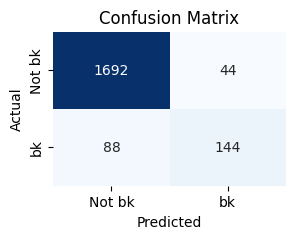

In [ ]:
evaluate_and_plot(true_labels_pool, predicted_labels_pool)

In [ ]:
model, criterion, optimizer = efficientnet_b0_model(seed=4)
model = model.to(device)
train_losses = []
train_accuracies = []
num_epochs = 100

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    total_samples = 0
    total_correct = 0
    for images,labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        output = model(images)
        output = output.squeeze(dim=1)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        total_samples += labels.size(0)
        total_correct += (output.round() == labels).sum().item()

        epoch_loss = train_loss / len(train_loader)
        epoch_acc = (total_correct / total_samples)*100
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_acc)

Loaded pretrained weights for efficientnet-b0


In [ ]:
true_labels1 = []
predicted_labels1 = []
model.eval()  
test_loss = 0.0
test_total_samples = 0
test_total_correct = 0
with torch.no_grad():  
    for images,labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        output = model(images)
        output = output.squeeze(dim=1)

        loss = criterion(output, labels)
        test_loss += loss.item()

        predicted = (output.round() == 1.0)  
        true_labels1.extend(labels.cpu().numpy())
        predicted_labels1.extend(predicted.cpu().numpy())        

        test_total_samples += labels.size(0)
        test_total_correct += (output.round() == labels).sum().item()

    test_accuracy = (test_total_correct / test_total_samples) * 100
    print(test_accuracy)

92.71844660194175


Accuracy: 0.9271844660194175
Precision: 0.7
Recall: 0.6712328767123288
F1 Score: 0.6853146853146853


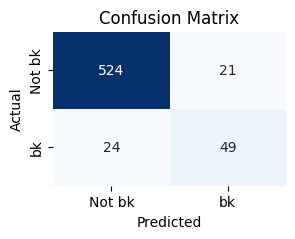

In [ ]:
evaluate_and_plot(true_labels1, predicted_labels1)

In [ ]:
# Assuming X_pool and y_pool are your pool data and labels
true_positive_indices = [i for i, (true_label, pred_label) in enumerate(zip(true_labels_pool, predicted_labels_pool)) if true_label == 1 and pred_label == 1]
false_positive_indices = [i for i, (true_label, pred_label) in enumerate(zip(true_labels_pool, predicted_labels_pool)) if true_label == 0 and pred_label == 1]

# Add true positives to the train dataset
x_train = np.vstack((x_train, x_pool[true_positive_indices]))
y_train = np.append(y_train, np.ones(len(true_positive_indices)))

# Add false positives to the train dataset
x_train = np.vstack((x_train, x_pool[false_positive_indices]))
y_train = np.append(y_train, np.zeros(len(false_positive_indices)))
# Drop true positives from pool data
x_pool = np.delete(x_pool, true_positive_indices, axis=0)
y_pool = np.delete(y_pool, true_positive_indices, axis=0)

# Drop false positives from pool data
x_pool = np.delete(x_pool, false_positive_indices, axis=0)
y_pool = np.delete(y_pool, false_positive_indices, axis=0)


IndexError: index 1891 is out of bounds for axis 0 with size 1824

In [ ]:
for iteration in range(5):
    print(f"Iteration {iteration + 1}")

    # Fit the classifier on the current train set
    model, criterion, optimizer = efficientnet_b0_model(seed=4)
    model = model.to(device)
    train_losses = []
    train_accuracies = []
    num_epochs = 10

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        total_samples = 0
        total_correct = 0
        for images,labels in train_loader:
            images = images.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            output = model(images)
            output = output.squeeze(dim=1)
            loss = criterion(output, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            total_samples += labels.size(0)
            total_correct += (output.round() == labels).sum().item()

            epoch_loss = train_loss / len(train_loader)
            epoch_acc = (total_correct / total_samples)*100
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_acc)
        print(f'Epoch {epoch+1}/{num_epochs}, Training Loss: {epoch_loss:.4f}, Training Accuracy: {epoch_acc:.4f}')
    # Predict on test data
    true_labels = []
    predicted_labels = []
    model.eval()  
    test_loss = 0.0
    test_total_samples = 0
    test_total_correct = 0
    with torch.no_grad():  
        for images,labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            output = model(images)
            output = output.squeeze(dim=1)

            loss = criterion(output, labels)
            test_loss += loss.item()

            predicted = (output.round() == 1.0)  
            true_labels.extend(labels.cpu().numpy())
            predicted_labels.extend(predicted.cpu().numpy())        

            test_total_samples += labels.size(0)
            test_total_correct += (output.round() == labels).sum().item()

        test_accuracy = (test_total_correct / test_total_samples) * 100
        evaluate_and_plot(true_labels, predicted_labels)

    # Make predictions on the pool set
    # Create directories to save true positive and false positive images
    true_positive_dir = f"true_positive_images{iteration + 1}"
    false_positive_dir = f"false_positive_images{iteration + 1}"

    os.makedirs(true_positive_dir, exist_ok=True)
    os.makedirs(false_positive_dir, exist_ok=True)

    # Define a transformation to convert tensor to PIL image
    transform = transforms.ToPILImage()

    true_labels_pool = []
    predicted_labels_pool = []
    model.eval()  
    test_loss = 0.0
    pool_total_samples = 0
    pool_total_correct = 0

    with torch.no_grad():  
        for i, (images, labels) in enumerate(pool_loader):
            images = images.to(device)
            labels = labels.to(device)
            output = model(images)
            output = output.squeeze(dim=1)

            loss = criterion(output, labels)
            test_loss += loss.item()

            predicted = (output.round() == 1.0)  
            true_labels_pool.extend(labels.cpu().numpy())
            predicted_labels_pool.extend(predicted.cpu().numpy())

            pool_total_samples += labels.size(0)
            pool_total_correct += (output.round() == labels).sum().item()

            # Save images classified as true positives and false positives
            for j in range(len(images)):
                if predicted[j] == 1 and labels[j] == 1:
                    # Save true positive image
                    img = transform(images[j].cpu())
                    img.save(os.path.join(true_positive_dir, f"true_positive_{i * pool_loader.batch_size + j}.png"))
                elif predicted[j] == 1 and labels[j] == 0:
                    # Save false positive image
                    img = transform(images[j].cpu())
                    img.save(os.path.join(false_positive_dir, f"false_positive_{i * pool_loader.batch_size + j}.png"))

    pool_accuracy = (pool_total_correct / pool_total_samples) * 100
    evaluate_and_plot(true_labels_pool, predicted_labels_pool)

    # Assuming X_pool and y_pool are your pool data and labels
    true_positive_indices = [i for i, (true_label, pred_label) in enumerate(zip(true_labels_pool, predicted_labels_pool)) if true_label == 1 and pred_label == 1]
    false_positive_indices = [i for i, (true_label, pred_label) in enumerate(zip(true_labels_pool, predicted_labels_pool)) if true_label == 0 and pred_label == 1]

    # Add true positives to the train dataset
    x_train = np.vstack((x_train, x_pool[true_positive_indices]))
    y_train = np.append(y_train, np.ones(len(true_positive_indices)))

    # Add false positives to the train dataset
    x_train = np.vstack((x_train, x_pool[false_positive_indices]))
    y_train = np.append(y_train, np.zeros(len(false_positive_indices)))
    
# Check the length of x_pool and y_pool
    num_samples = len(x_pool)

    # Filter out indices that are out of range
    true_positive_indices = [idx for idx in true_positive_indices if idx < num_samples]
    false_positive_indices = [idx for idx in false_positive_indices if idx < num_samples]

    # Drop true positives from pool data
    x_pool = np.delete(x_pool, true_positive_indices, axis=0)
    y_pool = np.delete(y_pool, true_positive_indices, axis=0)

    # Drop false positives from pool data
    x_pool = np.delete(x_pool, false_positive_indices, axis=0)
    y_pool = np.delete(y_pool, false_positive_indices, axis=0)

    # x_pool = x_pool.drop(x_pool.index[true_positive_indices + false_positive_indices])
    # y_pool = y_pool.drop(y_pool.index[true_positive_indices + false_positive_indices])

    print("X_train.shape:", x_train.shape)
    print("y_train.shape:", y_train.shape)
    print("X_pool.shape:", x_pool.shape)
    print("y_pool.shape:", y_pool.shape)


    resized_x_train = np.zeros((x_train.shape[0], 224, 224, 3), dtype=np.uint8)
    # print(resized_x_train.shape)
    resized_x_val = np.zeros((x_pool.shape[0], 224, 224, 3), dtype=np.uint8)
    for i in range(x_train.shape[0]):
        img = Image.fromarray(x_train[i])
        img = img.resize((224, 224), Image.ANTIALIAS)
        resized_x_train[i] = np.array(img)


    for i in range(x_pool.shape[0]):
        img = Image.fromarray(x_pool[i])
        img = img.resize((224, 224), Image.ANTIALIAS)
        resized_x_val[i] = np.array(img)

    train_dataset = TensorDataset(torch.tensor(x_train, dtype=torch.float32).permute(0, 3, 1, 2), torch.tensor(y_train, dtype=torch.float32))
    pool_dataset = TensorDataset(torch.tensor(x_pool, dtype=torch.float32).permute(0, 3, 1, 2), torch.tensor(y_pool, dtype=torch.float32))

    batch_size = 64
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    pool_loader = DataLoader(pool_dataset, batch_size=batch_size)


